In [1]:
import pandas as pd
import numpy as np
from os import getcwd, remove, listdir
from os.path import join 
import matplotlib.pyplot as plt
from lvm_read import read
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.tsa.ar_model import AutoReg,ar_select_order
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
from sklearn.manifold import TSNE
from scipy import stats
from sklearn.model_selection import (train_test_split, RepeatedKFold,
RandomizedSearchCV)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm


# Análise Exploratória

## Extração de características dos modelos AR

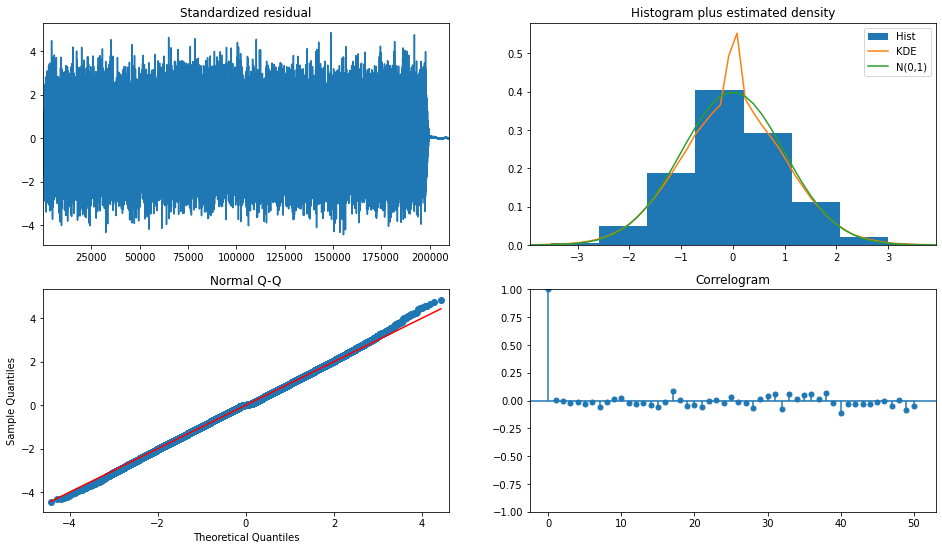

In [2]:
string="white_noise_"+str(1)+".lvm"
d=read(join(getcwd(),f'Case_R_(+25)/Case_R_(+25)_1/',string))
d[0]['Channel names'].pop()
df=pd.DataFrame(d[0]['data'],columns=d[0]['Channel names'])         
sel = ar_select_order(df["Ch2"],30)
sel.ar_lags
res = sel.model.fit()

fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=50)

In [3]:
# Params Download Data.
case_scheme = ["R","A","B","C","D","E","F","G","H","I","J","K","L"]
CH_numbers = 8
na = 17
df_AR = []
for jj, case in enumerate(case_scheme):
    try:
        [remove(join(getcwd(),f'Case_{case}_(+25)/Case_{case}_(+25)_1/',x)) for x in listdir(join(getcwd(),f'Case_{case}_(+25)/Case_{case}_(+25)_1/')) if '.pkl' in x]
        [remove(join(getcwd(),f'Case_{case}_(+25)/Case_{case}_(+25)_2/',x)) for x in listdir(join(getcwd(),f'Case_{case}_(+25)/Case_{case}_(+25)_2/')) if '.pkl' in x]
    except:
        continue
    for i in range(1, 41):
        if i > 20:
            ij = i-20
            sensor_scheme = "2"
        else:
            ij=i
            sensor_scheme ="1" # Sensor Scheme Choosed

        string="white_noise_"+str(ij)+".lvm"
        try:
            d=read(join(getcwd(),f'Case_{case}_(+25)/Case_{case}_(+25)_{sensor_scheme}/',string))
            d[0]['Channel names'].pop()
            df=pd.DataFrame(d[0]['data'],columns=d[0]['Channel names'])         
            ARmodel1 = AutoReg(df[f"Ch1"],na).fit()
            ARmodel2 = AutoReg(df[f"Ch2"],na).fit()
            ARmodel3 = AutoReg(df[f"Ch3"],na).fit()
            ARmodel4 = AutoReg(df[f"Ch4"],na).fit()
            ARmodel5 = AutoReg(df[f"Ch5"],na).fit()
            ARmodel6 = AutoReg(df[f"Ch6"],na).fit()
            ARmodel7 = AutoReg(df[f"Ch7"],na).fit()
            ARmodel8 = AutoReg(df[f"Ch8"],na).fit()
            ARparams=np.concatenate([ARmodel1.params,ARmodel2.params,ARmodel3.params,ARmodel4.params,
                                     ARmodel5.params,ARmodel6.params,ARmodel7.params,ARmodel8.params,[jj+1]])
            df_AR.append(ARparams)
            #print(case+" "+string)
        except:
            continue
df_AR=np.array(df_AR)


## Redução de dimensionalidade (PCA)

<Figure size 1008x504 with 0 Axes>

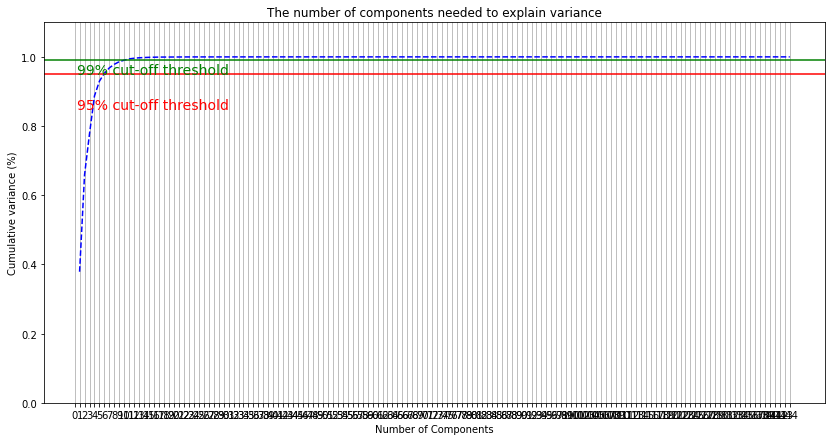

In [4]:
# PCA
pca = PCA().fit(df_AR[:,:-1])
plt.rcParams["figure.figsize"] = (14,7)
plt.figure()
fig, ax = plt.subplots()
exp_var = pca.explained_variance_ratio_
yi = np.cumsum(exp_var)
xi = np.arange(1, len(exp_var)+1, step=1)

plt.ylim(0.0,1.1)
plt.plot(xi, yi, linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0,len(exp_var)+1, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=14)
plt.axhline(y=0.99, color='g', linestyle='-')
plt.text(0.5, 0.95, '99% cut-off threshold', color = 'green', fontsize=14)

ax.grid(axis='x')
plt.show()

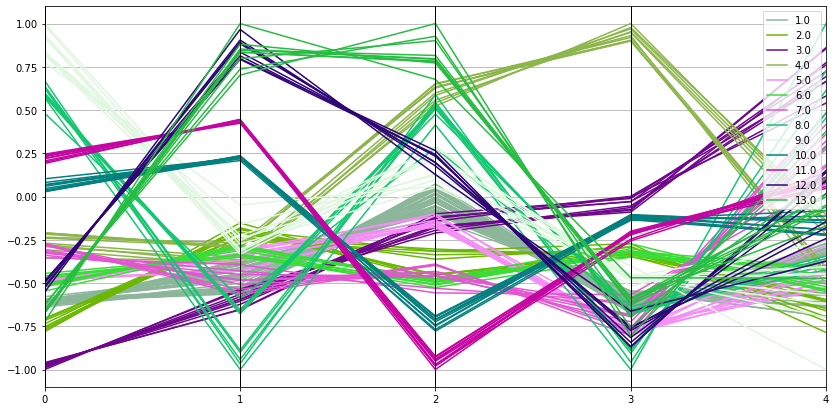

In [5]:
y_all = pd.DataFrame({'target':df_AR[:,-1]})
df_PCA = pd.DataFrame(PCA(n_components=5).fit_transform(df_AR[:,:-1]))#,columns=[f'{x} Component' for x in range(1,np.size(yi)+1)])
scaler = MinMaxScaler(feature_range=(-1,1))
df_all_PCA=pd.DataFrame(scaler.fit_transform(df_PCA))
df_parallel = pd.concat([df_all_PCA,y_all],axis=1)
temp = [str(x) for x in df_parallel['target']]
df_parallel['target'] = temp
fig = pd.plotting.parallel_coordinates(df_parallel,"target") # px.parallel_coordinates(df_parallel,)

<AxesSubplot:xlabel='variable', ylabel='value'>

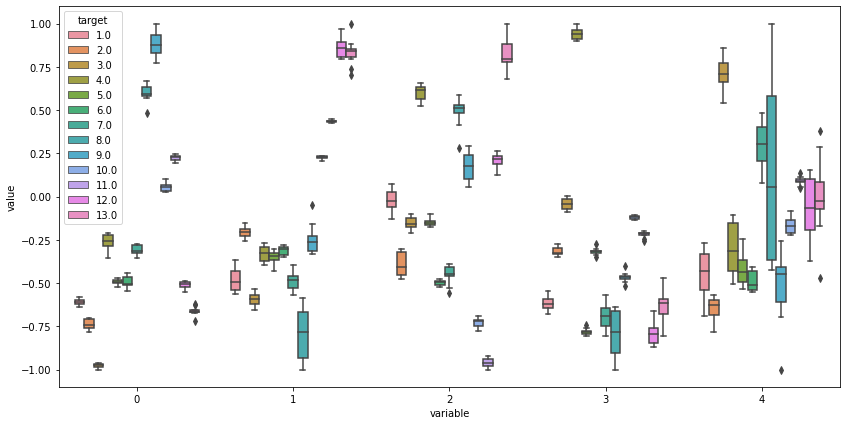

In [6]:
df_melted = df_parallel.melt(id_vars=['target'])
sns.boxplot(data = df_melted[df_melted['variable']<=10],x='variable',y='value',hue='target')

Text(0.5, 0.98, 'Dataset transformado por PCA e classificado pelo Label conhecido')

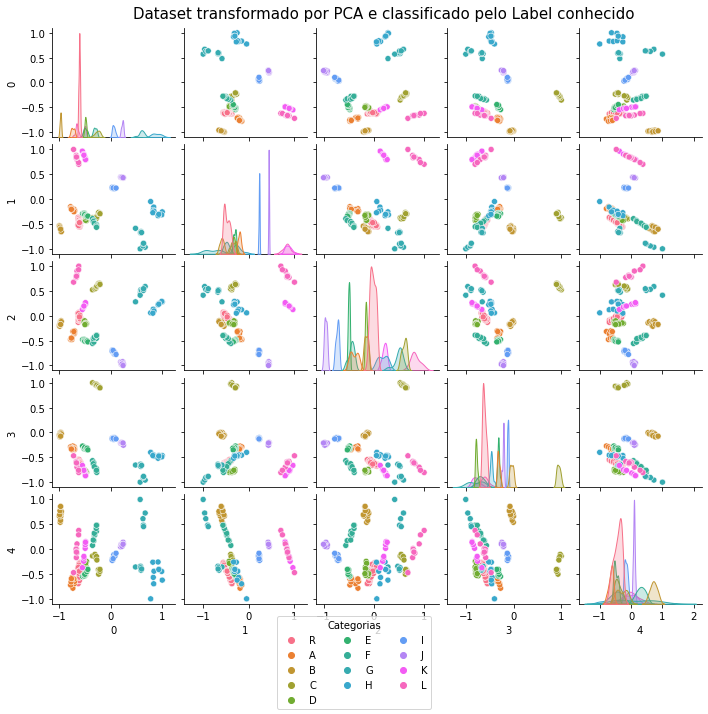

In [7]:
fig4=sns.pairplot(df_parallel,hue='target',height=2)
fig4._legend.remove()
handles = fig4._legend_data.values()
labels = case_scheme
fig4.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=3,title='Categorias')
fig4.fig.subplots_adjust(top=0.95, bottom=0.15)
fig4.fig.suptitle('Dataset transformado por PCA e classificado pelo Label conhecido',fontsize=15)

# Criação dos Modelos

In [8]:
models = []
models.append(("LRG",LogisticRegression()))
models.append(("SVC",SVC()))
models.append(("KNN",KNeighborsClassifier()))
param_grids =[]
param_grids.append( #Softmax
        {
            "LRG__C":[1, 10, 20, 60, 70, 100],
            "LRG__solver" :[ 'lbfgs', 'liblinear', 'sag'],
            "LRG__multi_class":['multinomial']  
        }
    
)
param_grids.append( #SVC
    
        {
            "SVC__C"      : stats.loguniform(1e-1,1e3),
            "SVC__kernel" : ['linear','poly','rbf','sigmoid'],
            "SVC__degree" : stats.randint(2,5),
            "SVC__gamma"  : stats.loguniform(1e-4,1e0),
            #"SVC__epsilon"  : stats.loguniform(1e-4,1e1)
        }
    
)
param_grids.append( #KNN
    
        {
            "KNN__n_neighbors" : stats.randint(2,100),
            "KNN__weights"      : ["uniform","distance"],
            "KNN__algorithm" : [ "ball_tree", "kd_tree", "brute"],
            "KNN__leaf_size" : stats.randint(1,30)            
        }
    
)

kfolds = 5
nkiter = 50
n_iter = 100

acc=[]
cfmx =[]
best_params =[]
x_train=[]
x_test=[]
y_train=[]
y_test=[]
yh_test=[]
acc=[]
cfmx =[]
best_params =[]

In [9]:
for it in tqdm(range(100)):
        train_x, test_x, train_y, test_y = train_test_split(df_parallel[df_parallel.columns[0:-1]], df_parallel.target, test_size=0.3, random_state=it)
        for i,md in enumerate(models):
        #print(f'Iteração {i+1} - {md}\n')
                rkf = RepeatedKFold(n_splits=kfolds,n_repeats=nkiter,random_state=None)

                clf = Pipeline([("scaler",StandardScaler()),(md)])

                param_grid = param_grids[i]
                rnd_model = RandomizedSearchCV(clf,verbose=0,n_iter=n_iter,n_jobs=6,cv=rkf,
                                                        random_state=None,param_distributions=param_grid,scoring=accuracy_score)
                rnd_model.fit(train_x,train_y)
                best_params.append(rnd_model.best_params_)
                yh_teste = rnd_model.predict(test_x)
                acc.append(accuracy_score(test_y, yh_teste,normalize=True))
                cfmx.append(confusion_matrix(test_y, yh_teste))
                #     x_train.append(train_x)
                y_train.append(train_y)
                #     x_test.append(test_x)
                y_test.append(test_y)
                yh_test.append(yh_teste)
    #print(f'Resultados: Acurácia={acc[i]}')
    #print(f'Beste Params: {best_params[i]}\n')

100%|██████████| 100/100 [55:26<00:00, 33.26s/it]


# Análise dos Resultados e Comparação entre Modelos

## Avaliação geral dos modelos
- Primeiro compara-se a performance de cada modelo quanto aos testes realizados na simulação baseada na simulação Monte Carlo
- Conforme ilustrado nos gráficos abaixo, a Regressão Logística possui a performance mais consistente quanto a acurácia de todos os testes de modelos. Além disto, o conjunto de parâmetros selecionado pelo RandomSearchCV foi o mesmo para todos os conjuntos de teste e treino.
- Os modelos SVC e KNN apresentaram diferentes valores de acurácia e diferentes parâmetros, mostrando-se muito sensíveis aos conjuntos de treino. Este pode ser percebido também na expressiva quantidade de modelos com acurácia 100%, destoando do resto dos cálculos, o que sugere um overfitting.

Text(0.5, 1.0, 'KNN')

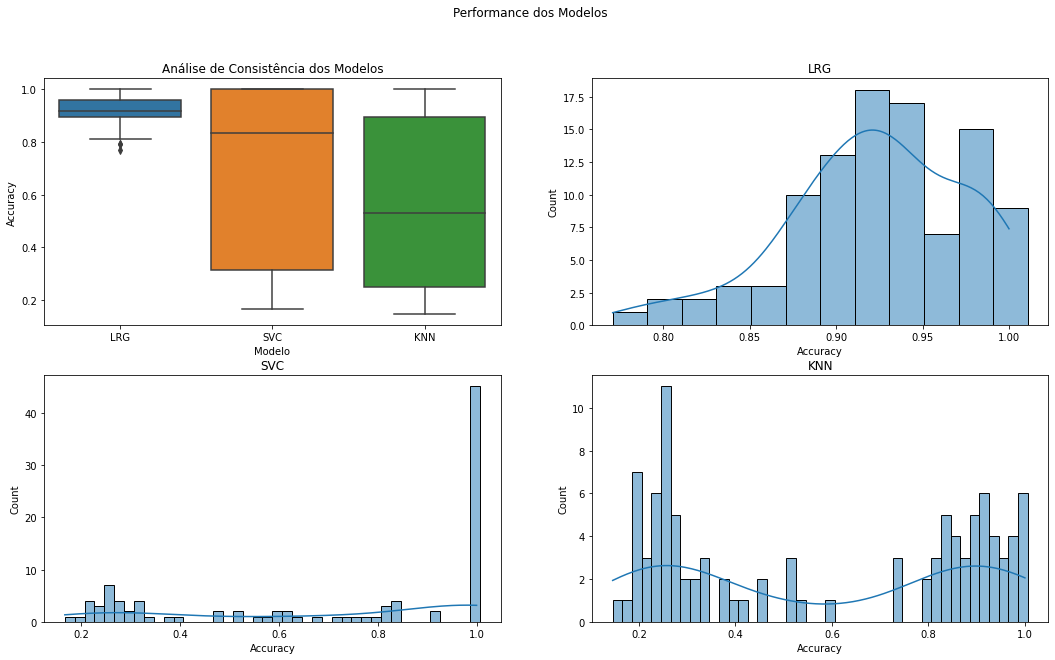

In [11]:
results=pd.concat([pd.DataFrame(best_params),pd.DataFrame(acc,columns=['Accuracy'])],axis=1)
dfLRG=results[['LRG__C','LRG__solver','LRG__multi_class','Accuracy']].copy().dropna()
dfSVC=results[['SVC__C','SVC__kernel','SVC__degree','SVC__gamma','Accuracy']].copy().dropna()
dfKNN=results[['KNN__n_neighbors','KNN__weights','KNN__algorithm','KNN__leaf_size','Accuracy']].copy().dropna()
dfLRG['Modelo']=str('LRG')
dfSVC['Modelo']=str('SVC')
dfKNN['Modelo']=str('KNN')
dfLRG['Hiperparâmetros']=dfLRG['LRG__C'].astype(str)+'_'+dfLRG['LRG__solver']+'_'+dfLRG['LRG__multi_class']
dfSVC['Hiperparâmetros']=dfSVC['SVC__C'].astype(str)+'_'+dfSVC['SVC__kernel'].astype(str)+'_'+dfSVC['SVC__degree'].astype(str)+'_'+dfSVC['SVC__gamma'].astype(str)
dfKNN['Hiperparâmetros']=dfKNN['KNN__n_neighbors'].astype(str)+'_'+dfKNN['KNN__weights'].astype(str)+'_'+dfKNN['KNN__algorithm'].astype(str)+'_'+dfKNN['KNN__leaf_size'].astype(str)
df_modelos=pd.concat([dfLRG[['Modelo','Hiperparâmetros', 'Accuracy']],dfSVC[['Modelo','Hiperparâmetros', 'Accuracy']],dfKNN[['Modelo','Hiperparâmetros', 'Accuracy']]])

fig, axes = plt.subplots(ncols=2, nrows=2,figsize=(18,10))
fig.suptitle('Performance dos Modelos')
sns.boxplot(data = df_modelos,x='Modelo',y='Accuracy',ax=axes[0,0]).set_title("Análise de Consistência dos Modelos")
sns.histplot(data=df_modelos[df_modelos['Modelo']=='LRG'], x="Accuracy",binwidth=0.02,kde=True,ax=axes[0,1]).set_title("LRG")
sns.histplot(data=df_modelos[df_modelos['Modelo']=='SVC'], x="Accuracy",binwidth=0.02,kde=True,ax=axes[1,0]).set_title("SVC")
sns.histplot(data=df_modelos[df_modelos['Modelo']=='KNN'], x="Accuracy",binwidth=0.02,kde=True,ax=axes[1,1]).set_title("KNN")

## Análise Exploratória dos Resultados do Modelo SVC

- Para melhor identificar o motivo pelo qual os modelos SVC e KNN tiveram performance ruim, realiza-se uma análise exploratória dos conjuntos de teste e treino e dos resultados da predição.
- Percebe-se pelas matrizes de confusão apresentadas abaixo que a baixa acurácia deve-se ao fato que todas as amostras foram classificadas como saudável.
- Quando observados os pairplots é possível notar que, em quase a totalidade dos componentes dos conjuntos de teste dos modelos com baixa acurácia, os dados nominais não são claramente distintos dos demais conjuntos.

[Text(0, 0.5, 'R'),
 Text(0, 1.5, 'A'),
 Text(0, 2.5, 'B'),
 Text(0, 3.5, 'C'),
 Text(0, 4.5, 'D'),
 Text(0, 5.5, 'E'),
 Text(0, 6.5, 'F'),
 Text(0, 7.5, 'G'),
 Text(0, 8.5, 'H'),
 Text(0, 9.5, 'I'),
 Text(0, 10.5, 'J'),
 Text(0, 11.5, 'K'),
 Text(0, 12.5, 'L')]

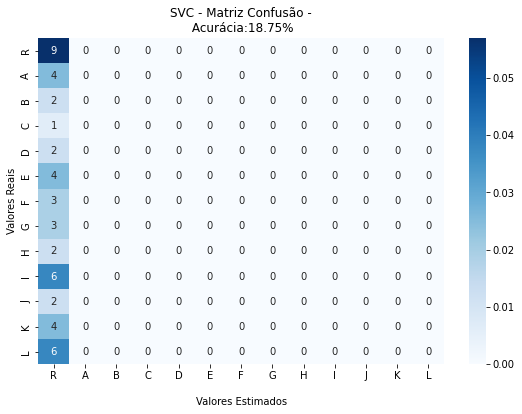

In [12]:
#index menor acuracia SVC
j=0
for ind in dfSVC['Accuracy']:
    if ind<0.2:
        break
    j+=1

train_x, test_x, train_y, test_y = train_test_split(df_parallel[df_parallel.columns[0:-1]], df_parallel.target, test_size=0.3, random_state=j)
dfruim_treino=pd.concat([pd.DataFrame(train_x),pd.DataFrame(train_y,columns=['target'])],axis=1)
dfruim_teste=pd.concat([pd.DataFrame(test_x),pd.DataFrame(test_y,columns=['target'])],axis=1)

ilrg=j*3
isvc=j*3+1
iknn=j*3+2

#matriz de confusao SVC
fig = plt.figure(figsize=(20,6))
#plt.figure(facecolor='White',figsize=(30,10), dpi=80)
plt.subplot(121)
group_counts_x1 = ["{0:0.0f}".format(value) for value in
                cfmx[isvc].flatten()]            
group_percentages_x1 = ["{0:.2%}".format(value) for value in
                     cfmx[isvc].flatten()/np.sum(cfmx[isvc])]                 
labels_x1 = [f"{v2}" for v2, v3 in
          zip(group_counts_x1,group_percentages_x1)]
labels_x1 = np.asarray(labels_x1).reshape(cfmx[isvc].shape)
ax1 = sns.heatmap(cfmx[isvc]/len(df_parallel['target']), annot=labels_x1,  cmap='Blues', fmt='')
ax1.set_title(f'SVC - Matriz Confusão -\n Acurácia:{round(100*acc[isvc],2)}%')
ax1.set_xlabel('\nValores Estimados')
ax1.set_ylabel('Valores Reais')
## Ticket labels - List must be in alphabetical order
ax1.xaxis.set_ticklabels(case_scheme)
ax1.yaxis.set_ticklabels(case_scheme)

#matriz de confusao knn
# plt.subplot(122)
# group_counts_x1 = ["{0:0.0f}".format(value) for value in
#                 cfmx[iknn].flatten()]            
# group_percentages_x1 = ["{0:.2%}".format(value) for value in
#                      cfmx[iknn].flatten()/np.sum(cfmx[iknn])]                 
# labels_x1 = [f"{v2}" for v2, v3 in
#           zip(group_counts_x1,group_percentages_x1)]
# labels_x1 = np.asarray(labels_x1).reshape(cfmx[iknn].shape)
# ax1 = sns.heatmap(cfmx[iknn]/len(df_parallel['target']), annot=labels_x1,  cmap='Blues', fmt='')
# ax1.set_title(f'KNN - Matriz Confusão -\n Acurácia:{round(100*acc[iknn],2)}%')
# ax1.set_xlabel('\nValores Estimados')
# ax1.set_ylabel('Valores Reais')
# ## Ticket labels - List must be in alphabetical order
# ax1.xaxis.set_ticklabels(case_scheme)
# ax1.yaxis.set_ticklabels(case_scheme)
# #matriz de confusao lrg
# fig = plt.figure(figsize=(16, 9))
# plt.figure(facecolor='White',figsize=(30, 5), dpi=80)
# plt.subplot(131)
# group_counts_x1 = ["{0:0.0f}".format(value) for value in
#                 cfmx[ilrg].flatten()]            
# group_percentages_x1 = ["{0:.2%}".format(value) for value in
#                      cfmx[ilrg].flatten()/np.sum(cfmx[ilrg])]                 
# labels_x1 = [f"{v2}" for v2, v3 in
#           zip(group_counts_x1,group_percentages_x1)]
# labels_x1 = np.asarray(labels_x1).reshape(cfmx[ilrg].shape)
# ax1 = sns.heatmap(cfmx[ilrg]/len(df_parallel['target']), annot=labels_x1,  cmap='Blues', fmt='')
# ax1.set_title(f'Softmax - Matriz Confusão -\n Acurácia:{round(100*acc[ilrg],2)}%')
# ax1.set_xlabel('\nValores Estimados')
# ax1.set_ylabel('Valores Reais')
# ## Ticket labels - List must be in alphabetical order
# ax1.xaxis.set_ticklabels(case_scheme)
# ax1.yaxis.set_ticklabels(case_scheme)




Text(0.5, 0.98, 'Dataset de Teste com Resultado Ruim')

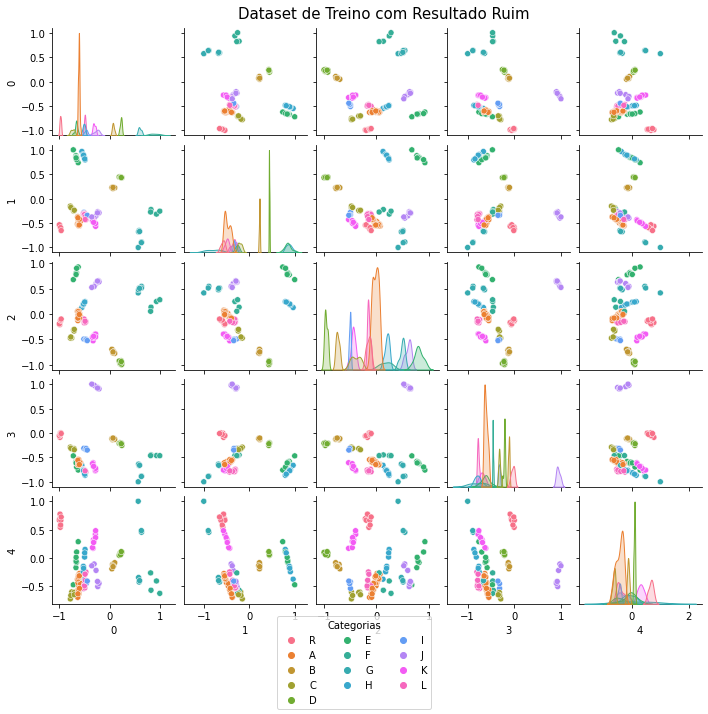

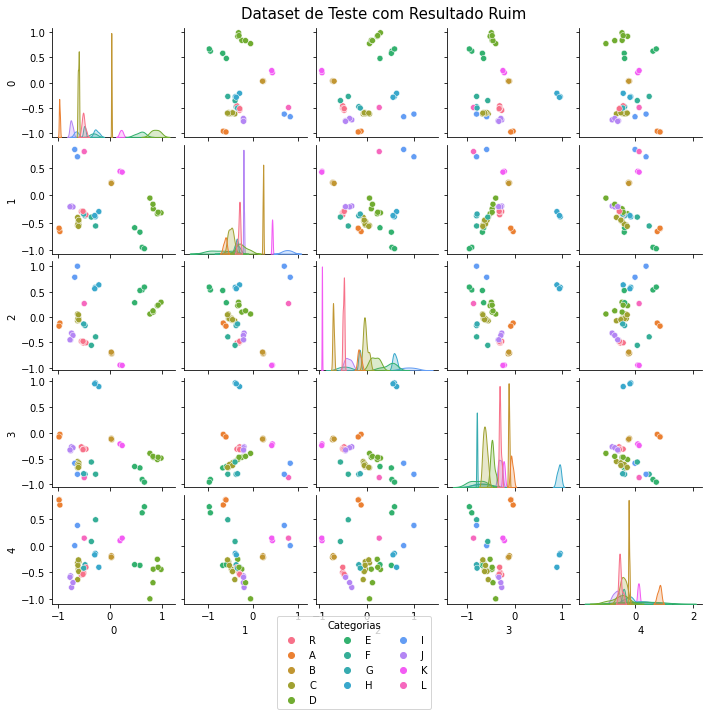

In [13]:
fig4=sns.pairplot(dfruim_treino,hue='target',height=2)
fig4._legend.remove()
handles = fig4._legend_data.values()
labels = case_scheme
fig4.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=3,title='Categorias')
fig4.fig.subplots_adjust(top=0.95, bottom=0.15)
fig4.fig.suptitle('Dataset de Treino com Resultado Ruim',fontsize=15)

fig5=sns.pairplot(dfruim_teste,hue='target',height=2)
fig5._legend.remove()
handles = fig5._legend_data.values()
labels = case_scheme
fig5.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=3,title='Categorias')
fig5.fig.subplots_adjust(top=0.95, bottom=0.15)
fig5.fig.suptitle('Dataset de Teste com Resultado Ruim',fontsize=15)

[Text(0, 0.5, 'R'),
 Text(0, 1.5, 'A'),
 Text(0, 2.5, 'B'),
 Text(0, 3.5, 'C'),
 Text(0, 4.5, 'D'),
 Text(0, 5.5, 'E'),
 Text(0, 6.5, 'F'),
 Text(0, 7.5, 'G'),
 Text(0, 8.5, 'H'),
 Text(0, 9.5, 'I'),
 Text(0, 10.5, 'J'),
 Text(0, 11.5, 'K'),
 Text(0, 12.5, 'L')]

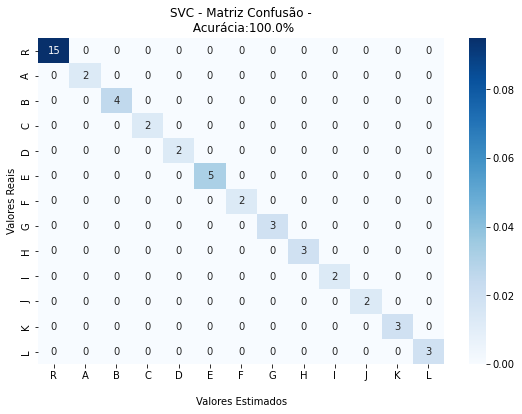

In [14]:
#index menor acuracia SVC
jj=0
for ind in dfSVC['Accuracy']:
    if ind>0.8:
        break
    jj+=1

train_x, test_x, train_y, test_y = train_test_split(df_parallel[df_parallel.columns[0:-1]], df_parallel.target, test_size=0.3, random_state=jj)
dfbom_treino=pd.concat([pd.DataFrame(train_x),pd.DataFrame(train_y,columns=['target'])],axis=1)
dfbom_teste=pd.concat([pd.DataFrame(test_x),pd.DataFrame(test_y,columns=['target'])],axis=1)

ilrg=jj*3
isvc=jj*3+1
iknn=jj*3+2

#matriz de confusao SVC
fig = plt.figure(figsize=(20,6))
#plt.figure(facecolor='White',figsize=(30,10), dpi=80)
plt.subplot(121)
group_counts_x1 = ["{0:0.0f}".format(value) for value in
                cfmx[isvc].flatten()]            
group_percentages_x1 = ["{0:.2%}".format(value) for value in
                     cfmx[isvc].flatten()/np.sum(cfmx[isvc])]                 
labels_x1 = [f"{v2}" for v2, v3 in
          zip(group_counts_x1,group_percentages_x1)]
labels_x1 = np.asarray(labels_x1).reshape(cfmx[isvc].shape)
ax1 = sns.heatmap(cfmx[isvc]/len(df_parallel['target']), annot=labels_x1,  cmap='Blues', fmt='')
ax1.set_title(f'SVC - Matriz Confusão -\n Acurácia:{round(100*acc[isvc],2)}%')
ax1.set_xlabel('\nValores Estimados')
ax1.set_ylabel('Valores Reais')
## Ticket labels - List must be in alphabetical order
ax1.xaxis.set_ticklabels(case_scheme)
ax1.yaxis.set_ticklabels(case_scheme)

#matriz de confusao knn
# plt.subplot(122)
# group_counts_x1 = ["{0:0.0f}".format(value) for value in
#                 cfmx[iknn].flatten()]            
# group_percentages_x1 = ["{0:.2%}".format(value) for value in
#                      cfmx[iknn].flatten()/np.sum(cfmx[iknn])]                 
# labels_x1 = [f"{v2}" for v2, v3 in
#           zip(group_counts_x1,group_percentages_x1)]
# labels_x1 = np.asarray(labels_x1).reshape(cfmx[iknn].shape)
# ax1 = sns.heatmap(cfmx[iknn]/len(df_parallel['target']), annot=labels_x1,  cmap='Blues', fmt='')
# ax1.set_title(f'KNN - Matriz Confusão -\n Acurácia:{round(100*acc[iknn],2)}%')
# ax1.set_xlabel('\nValores Estimados')
# ax1.set_ylabel('Valores Reais')
# ## Ticket labels - List must be in alphabetical order
# ax1.xaxis.set_ticklabels(case_scheme)
# ax1.yaxis.set_ticklabels(case_scheme)
# #matriz de confusao lrg
# fig = plt.figure(figsize=(16, 9))
# plt.figure(facecolor='White',figsize=(30, 5), dpi=80)
# plt.subplot(131)
# group_counts_x1 = ["{0:0.0f}".format(value) for value in
#                 cfmx[ilrg].flatten()]            
# group_percentages_x1 = ["{0:.2%}".format(value) for value in
#                      cfmx[ilrg].flatten()/np.sum(cfmx[ilrg])]                 
# labels_x1 = [f"{v2}" for v2, v3 in
#           zip(group_counts_x1,group_percentages_x1)]
# labels_x1 = np.asarray(labels_x1).reshape(cfmx[ilrg].shape)
# ax1 = sns.heatmap(cfmx[ilrg]/len(df_parallel['target']), annot=labels_x1,  cmap='Blues', fmt='')
# ax1.set_title(f'Softmax - Matriz Confusão -\n Acurácia:{round(100*acc[ilrg],2)}%')
# ax1.set_xlabel('\nValores Estimados')
# ax1.set_ylabel('Valores Reais')
# ## Ticket labels - List must be in alphabetical order
# ax1.xaxis.set_ticklabels(case_scheme)
# ax1.yaxis.set_ticklabels(case_scheme)

Text(0.5, 0.98, 'Dataset de Teste com Resultado Bom')

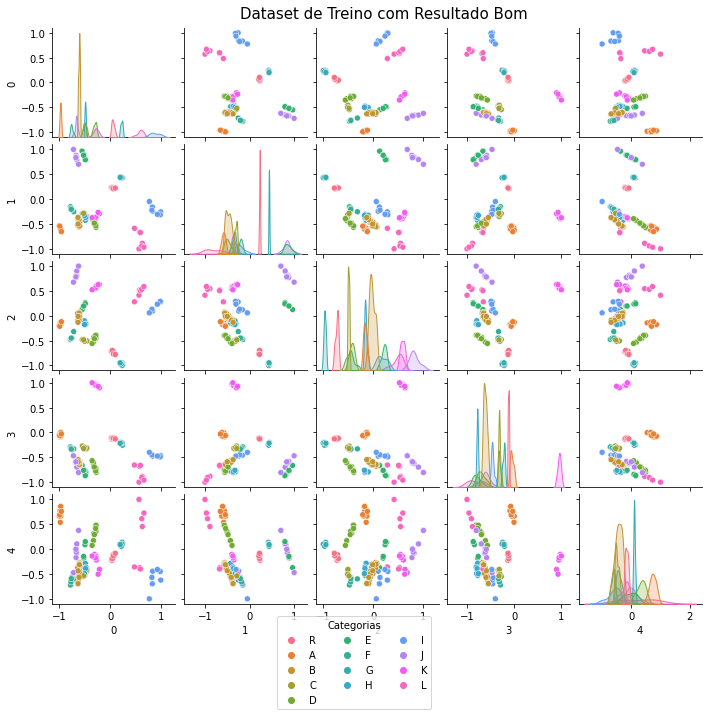

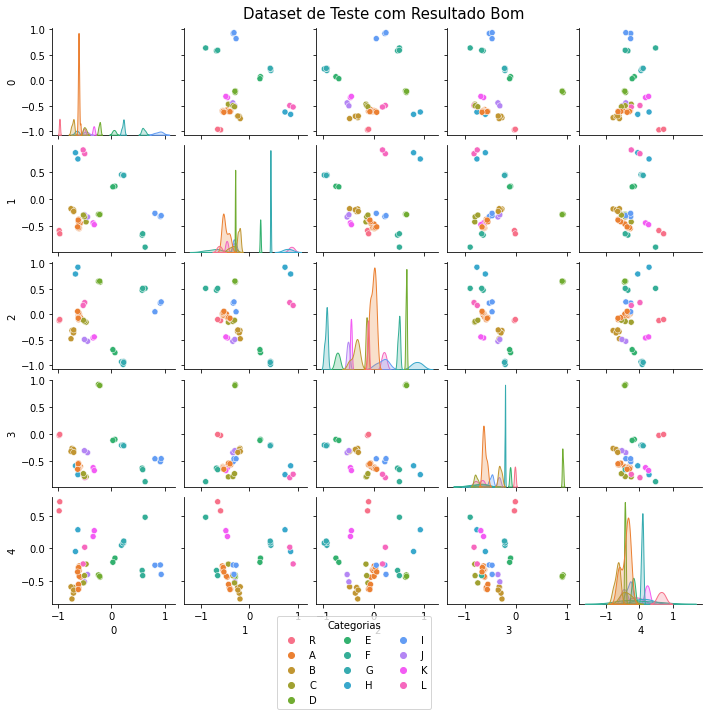

In [15]:
fig4=sns.pairplot(dfbom_treino,hue='target',height=2)
fig4._legend.remove()
handles = fig4._legend_data.values()
labels = case_scheme
fig4.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=3,title='Categorias')
fig4.fig.subplots_adjust(top=0.95, bottom=0.15)
fig4.fig.suptitle('Dataset de Treino com Resultado Bom',fontsize=15)

fig5=sns.pairplot(dfbom_teste,hue='target',height=2)
fig5._legend.remove()
handles = fig5._legend_data.values()
labels = case_scheme
fig5.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=3,title='Categorias')
fig5.fig.subplots_adjust(top=0.95, bottom=0.15)
fig5.fig.suptitle('Dataset de Teste com Resultado Bom',fontsize=15)

## Análise Exploratória dos Resultados do Modelo KNN

[Text(0, 0.5, 'R'),
 Text(0, 1.5, 'A'),
 Text(0, 2.5, 'B'),
 Text(0, 3.5, 'C'),
 Text(0, 4.5, 'D'),
 Text(0, 5.5, 'E'),
 Text(0, 6.5, 'F'),
 Text(0, 7.5, 'G'),
 Text(0, 8.5, 'H'),
 Text(0, 9.5, 'I'),
 Text(0, 10.5, 'J'),
 Text(0, 11.5, 'K'),
 Text(0, 12.5, 'L')]

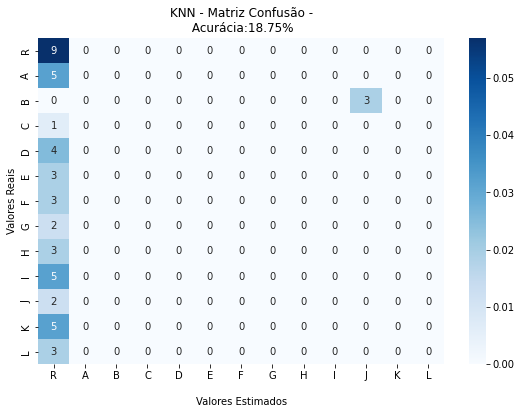

In [16]:
#index menor acuracia SVC
j=0
for ind in dfKNN['Accuracy']:
    if ind<0.2:
        break
    j+=1

train_x, test_x, train_y, test_y = train_test_split(df_parallel[df_parallel.columns[0:-1]], df_parallel.target, test_size=0.3, random_state=j)
dfruim_treino=pd.concat([pd.DataFrame(train_x),pd.DataFrame(train_y,columns=['target'])],axis=1)
dfruim_teste=pd.concat([pd.DataFrame(test_x),pd.DataFrame(test_y,columns=['target'])],axis=1)

ilrg=j*3
isvc=j*3+1
iknn=j*3+2

#matriz de confusao SVC
fig = plt.figure(figsize=(20,6))
#plt.figure(facecolor='White',figsize=(30,10), dpi=80)
plt.subplot(121)
group_counts_x1 = ["{0:0.0f}".format(value) for value in
                cfmx[iknn].flatten()]            
group_percentages_x1 = ["{0:.2%}".format(value) for value in
                     cfmx[iknn].flatten()/np.sum(cfmx[iknn])]                 
labels_x1 = [f"{v2}" for v2, v3 in
          zip(group_counts_x1,group_percentages_x1)]
labels_x1 = np.asarray(labels_x1).reshape(cfmx[iknn].shape)
ax1 = sns.heatmap(cfmx[iknn]/len(df_parallel['target']), annot=labels_x1,  cmap='Blues', fmt='')
ax1.set_title(f'KNN - Matriz Confusão -\n Acurácia:{round(100*acc[iknn],2)}%')
ax1.set_xlabel('\nValores Estimados')
ax1.set_ylabel('Valores Reais')
## Ticket labels - List must be in alphabetical order
ax1.xaxis.set_ticklabels(case_scheme)
ax1.yaxis.set_ticklabels(case_scheme)

Text(0.5, 0.98, 'Dataset de Teste com Resultado Ruim')

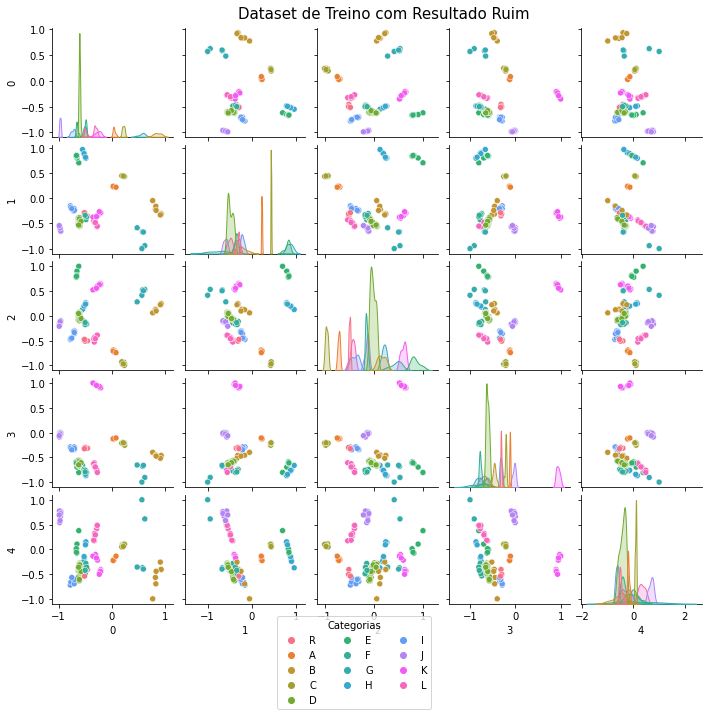

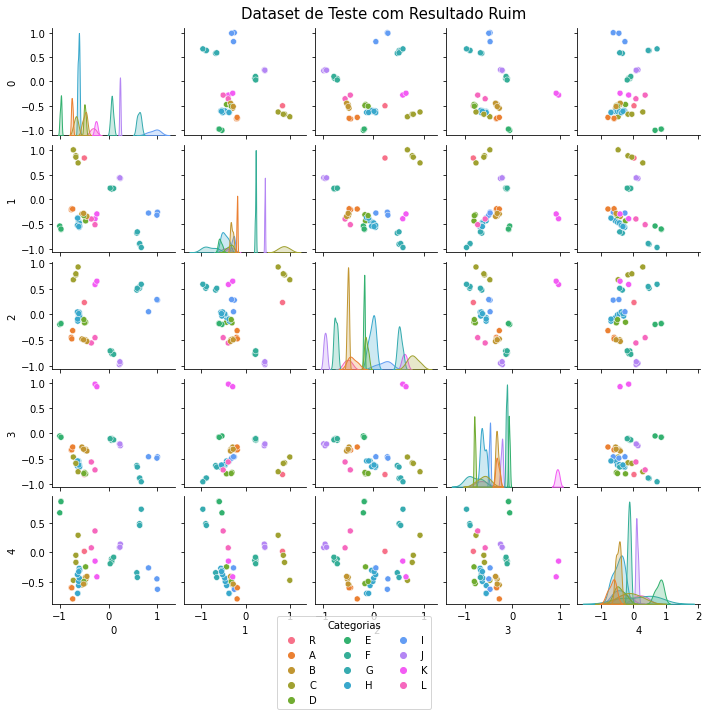

In [17]:
fig4=sns.pairplot(dfruim_treino,hue='target',height=2)
fig4._legend.remove()
handles = fig4._legend_data.values()
labels = case_scheme
fig4.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=3,title='Categorias')
fig4.fig.subplots_adjust(top=0.95, bottom=0.15)
fig4.fig.suptitle('Dataset de Treino com Resultado Ruim',fontsize=15)

fig5=sns.pairplot(dfruim_teste,hue='target',height=2)
fig5._legend.remove()
handles = fig5._legend_data.values()
labels = case_scheme
fig5.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=3,title='Categorias')
fig5.fig.subplots_adjust(top=0.95, bottom=0.15)
fig5.fig.suptitle('Dataset de Teste com Resultado Ruim',fontsize=15)